# Machine Exercise 7
## Miguel Luis Martinez, Juan Carlos Roldan, Jeryl Salas | AI 221 WZZQ  Shannon Batch | University of the Philippines Diliman

In [ ]:
!pip install ucimlrepo optuna shap lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.6 MB/s eta 0:00:00


# 1. Early Stage Diabetes Risk Prediction

This dataset contains information on about 500 patients in Bangladesh. Our goal is to predict whether a patient is Positive / Negative for diabetes -- a binary classification problem. The input features

In [ ]:
import pandas as pd

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv"
data = pd.read_csv(url)

# Display the first few rows of the dataset
data.head()


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


 # Part 1: Trip Advisor Travel Reviews
This is a dataset consisting of 500+ questionnaers from patients in Sylhet Diabetes Hospital in Sylhet, Bangladesh. The features included in this dataset are age, gender, polyuria, polydipsia, sudden_weight_loss, weakness, polyphagia, genital_thrush, visual_blurring, and itching. Using Optuna, we performed a binary classification by optimizing the best model among MLP Classifier, Random Forest Classifier, XGBoost Classifier, Logistic Regression, Naïve Bayes Classifier, SVM Classifier
(SVC), and kNN Classifier


## 1.A Data Processing
We encoded all categorical features in the dataset using LabelEncoder storing each encoder in a dictionary. We defined X as features and y as target. We then used train_test_split to 80-20 split the dataset for training and testing.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
label_encoders = {}
for column in data.columns:
    if data[column].dtype == 'object':
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

# Split the data into features and target
X = data.drop('class', axis=1)
y = data['class']

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## 1.B Optuna
Using Optuna, weidentify the best-performing model and hyperparameters for classification task. We defined an objective function that suggests various classifiers and their corresponding hyperparameters. We then evaluated the model's performance using 10-fold cross-validation and returned the accuracy score. Our objective is to get the highest possible accuracy score out of the hyperparameter and model combination after 100 trials. After 100 trials, the highest training accuracy we were able to get was 0.9784 using the XGBoost model with 914 estimators, a max depth of 3, a learning rate of 0.0698, and a sub sample of 0.5078. This model also had an F1 score of 0.9809.  

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def objective(trial):
    classifier_name = trial.suggest_categorical("classifier", ["MLP", "RandomForest", "XGBoost", "LogisticRegression", "NaiveBayes", "SVC", "kNN"])

    if classifier_name == "MLP":
        hidden_layer_sizes = trial.suggest_categorical("MLP_hidden_layer_sizes", [(50,50,50), (50,100,50), (100,)])
        activation = trial.suggest_categorical("MLP_activation", ["tanh", "relu"])
        solver = trial.suggest_categorical("MLP_solver", ["sgd", "adam"])
        alpha = trial.suggest_loguniform("MLP_alpha", 1e-5, 1e-2)
        learning_rate = trial.suggest_categorical("MLP_learning_rate", ["constant", "adaptive"])
        model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver, alpha=alpha, learning_rate=learning_rate)

    elif classifier_name == "RandomForest":
        n_estimators = trial.suggest_int("RF_n_estimators", 100, 1000)
        max_depth = trial.suggest_int("RF_max_depth", 2, 32, log=True)
        min_samples_split = trial.suggest_int("RF_min_samples_split", 2, 14)
        min_samples_leaf = trial.suggest_int("RF_min_samples_leaf", 1, 14)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

    elif classifier_name == "XGBoost":
        n_estimators = trial.suggest_int("XGB_n_estimators", 100, 1000)
        max_depth = trial.suggest_int("XGB_max_depth", 2, 32, log=True)
        learning_rate = trial.suggest_loguniform("XGB_learning_rate", 0.01, 0.1)
        subsample = trial.suggest_uniform("XGB_subsample", 0.5, 1.0)
        model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample)

    elif classifier_name == "LogisticRegression":
        C = trial.suggest_loguniform("LR_C", 1e-5, 1e2)
        solver = trial.suggest_categorical("LR_solver", ["lbfgs", "liblinear"])
        model = LogisticRegression(C=C, solver=solver)

    elif classifier_name == "NaiveBayes":
        model = GaussianNB()

    elif classifier_name == "SVC":
        C = trial.suggest_loguniform("SVC_C", 1e-5, 1e2)
        gamma = trial.suggest_loguniform("SVC_gamma", 1e-5, 1e-1)
        model = SVC(C=C, gamma=gamma)

    elif classifier_name == "kNN":
        n_neighbors = trial.suggest_int("kNN_n_neighbors", 1, 20)
        weights = trial.suggest_categorical("kNN_weights", ["uniform", "distance"])
        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=10)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
print(f"Best trial: {best_trial.value}")
print("Best hyperparameters: ", best_trial.params)


[I 2024-06-14 06:34:01,658] A new study created in memory with name: no-name-e9060167-0f52-405a-9960-0edd5cf1a2b8
<ipython-input-12-8a0918394d7e>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("LR_C", 1e-5, 1e2)
[I 2024-06-14 06:34:02,463] Trial 0 finished with value: 0.9207317073170733 and parameters: {'classifier': 'LogisticRegression', 'LR_C': 12.53590918983361, 'LR_solver': 'lbfgs'}. Best is trial 0 with value: 0.9207317073170733.
<ipython-input-12-8a0918394d7e>:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("LR_C", 1e-5, 1e2)
[I 2024-06-14 06:34:03,060] Trial 1 finished with value: 0.7497677119628338 a

Best trial: 0.9783972125435539
Best hyperparameters:  {'classifier': 'XGBoost', 'XGB_n_estimators': 914, 'XGB_max_depth': 3, 'XGB_learning_rate': 0.06979949030524546, 'XGB_subsample': 0.5078136617336291}


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Train the best model on the full training data
best_params = best_trial.params
classifier_name = best_params.pop("classifier")
if classifier_name == "MLP":
    model = MLPClassifier(**best_params)
elif classifier_name == "RandomForest":
    model = RandomForestClassifier(**best_params)
elif classifier_name == "XGBoost":
    model = XGBClassifier(**best_params)
elif classifier_name == "LogisticRegression":
    model = LogisticRegression(**best_params)
elif classifier_name == "NaiveBayes":
    model = GaussianNB()
elif classifier_name == "SVC":
    model = SVC(**best_params)
elif classifier_name == "kNN":
    model = KNeighborsClassifier(**best_params)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Accuracy: 0.9807692307692307
F1 Score: 0.9808511271925906


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:45:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "XGB_learning_rate", "XGB_max_depth", "XGB_n_estimators", "XGB_subsample" } are not used.

  warnings.warn(smsg, UserWarning)


# 1.C Search for higher accuracy score

As stated from the paper Islam, M.M.F., et. Al. (2020), the best result was found to be random forest in which they had a weighted average F1 score of 0.98 By doing hyperparameter search using Optuna, we were able to find a better result with a F1 score of 0.9904 and an accuracy of 0.9903 using Random Forest 535 estimators, max depth of 28, minimal sample split of 3, minimal sample leaf of 1

### Using Optuna

In [ ]:
def rf_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 32, log=True),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 14),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 14),
    }
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=10)
    accuracy = score.mean()
    return accuracy

rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_objective, n_trials=100)

best_rf_trial = rf_study.best_trial
print(f"Best Random Forest trial: {best_rf_trial.value}")
print("Best hyperparameters for Random Forest: ", best_rf_trial.params)

# Train and evaluate the best Random Forest model
best_rf_params = best_rf_trial.params
rf_model = RandomForestClassifier(**best_rf_params)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_rf_pred)
rf_f1 = f1_score(y_test, y_rf_pred, average='weighted')
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest F1 Score: {rf_f1}")


[I 2024-06-14 06:46:12,730] A new study created in memory with name: no-name-d227114f-cd72-4d58-9fe9-2078711c7a55
[I 2024-06-14 06:46:22,644] Trial 0 finished with value: 0.9061556329849012 and parameters: {'n_estimators': 250, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9061556329849012.
[I 2024-06-14 06:46:31,466] Trial 1 finished with value: 0.9062137049941927 and parameters: {'n_estimators': 430, 'max_depth': 3, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.9062137049941927.
[I 2024-06-14 06:46:33,515] Trial 2 finished with value: 0.8916957026713126 and parameters: {'n_estimators': 157, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.9062137049941927.
[I 2024-06-14 06:46:45,748] Trial 3 finished with value: 0.8941347270615564 and parameters: {'n_estimators': 768, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 13}. Best is trial 1 with valu

Best Random Forest trial: 0.9807781649245063
Best hyperparameters for Random Forest:  {'n_estimators': 535, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 1}
Random Forest Accuracy: 0.9903846153846154
Random Forest F1 Score: 0.9904061137656939


### Using Grid Search

### Using Bayesian Optimization

In [ ]:
# from hyperopt import fmin, tpe, hp, Trials
# from hyperopt.pyll.base import scope
# from sklearn.model_selection import cross_val_score

# # Define the search space
# space = {
#     'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 1)),
#     'max_depth': scope.int(hp.quniform('max_depth', 2, 50, 1)),
#     'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 14, 1)),
#     'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 14, 1))
# }

# # Define the objective function
# def objective(params):
#     rf = RandomForestClassifier(**params)
#     score = cross_val_score(rf, X_train, y_train, cv=10, n_jobs=-1).mean()
#     return -score

# # Initialize trials object
# trials = Trials()

# # Run the optimization
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials, rstate=np.random.RandomState(42))

# print(f"Best parameters: {best}")

# # Convert best parameters to int
# best_params = {k: int(v) for k, v in best.items()}

# # Train and evaluate the best model
# best_rf = RandomForestClassifier(**best_params)
# best_rf.fit(X_train, y_train)
# y_rf_pred = best_rf.predict(X_test)

# rf_accuracy = accuracy_score(y_test, y_rf_pred)
# rf_f1 = f1_score(y_test, y_rf_pred, average='weighted')
# print(f"Random Forest Accuracy: {rf_accuracy}")
# print(f"Random Forest F1 Score: {rf_f1}")


# 2. Predicting High School Student Performance

The goal here is to use the Student Performance data set from the UCI Repository (https://archive.ics.uci.edu/ml/datasets/Student+Performance) to predict G1, G2, and G3, which are the 1st, 2nd, and 3rd period grades, respectively. This is a regression problem.

The dataset contains 30 descriptors on 600+ students from two Portuguese schools. The accompanying paper to this data set was done by Paulo Cortez and Alice Silva, entitled "Using Data Mining to Predict Secondary School Student Performance" (http://www3.dsi.uminho.pt/pcortez/student.pdf).

Note: We will only be dealing with the math scores for these specific sets of students.

In [ ]:
import zipfile
import pandas as pd
import requests
from io import BytesIO

# Download the zip file
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))

# Extract the contents of the zip file
zip_file.extractall()

# Load the specific CSV file into a DataFrame
data = pd.read_csv("student-mat.csv", sep=";")

# Display the first few rows of the DataFrame
print(data.head())


  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]


## 2A: Data Preprocessing

In this first part, we will first be making the necessary encoding for categorical inputs. We will be splitting the data into 80% Training and 20% Test sets.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Split the data into training and testing sets
X = data.drop(['G1', 'G2', 'G3'], axis=1)
y = data[['G1', 'G2', 'G3']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 2B: Auto-ML Application

In this second phase, we will be running any Auto-ML procedure (either LazyPredict, Optuna, TPOT) to predict the G3 score using the 30 descriptors and the G1 and G2 scores as input features (32 features in all). We will be using Optuna specifically for this exercise across 3 different ML models: RandomForestRegressor, GradientBoostingRegressor, and XGBRegressor.


In [ ]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

# Load the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
data = pd.read_csv("student-mat.csv", sep=";")

# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Define features and target
X = data.drop(['G3'], axis=1)
y = data['G3']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Define model selection
    model_name = trial.suggest_categorical('model', ['RandomForest', 'GradientBoosting', 'XGBoost'])

    if model_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 14)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 14)
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )

    elif model_name == 'GradientBoosting':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=42
        )

    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 10, 200)
        max_depth = trial.suggest_int('max_depth', 2, 32)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        model = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=42
        )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate the R2 score
    score = r2_score(y_test, y_pred)

    return score

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# Print the best hyperparameters and model
print(f"Best model: {study.best_trial.params['model']}")
print(f"Best hyperparameters: {study.best_params}")
print(f"Best R2 score: {study.best_value}")

# Train the final model with the best hyperparameters
best_model_name = study.best_trial.params['model']
best_params = study.best_params

if best_model_name == 'RandomForest':
    best_model = RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )

elif best_model_name == 'GradientBoosting':
    best_model = GradientBoostingRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        random_state=42
    )

elif best_model_name == 'XGBoost':
    best_model = XGBRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        random_state=42
    )

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
final_score = r2_score(y_test, y_pred)
print(f"Final R2 score: {final_score}")


[I 2024-06-15 13:11:25,624] A new study created in memory with name: no-name-d30904d4-6477-48c9-9246-dfc251522c34
[I 2024-06-15 13:11:26,218] Trial 0 finished with value: 0.7400195684951455 and parameters: {'model': 'GradientBoosting', 'n_estimators': 135, 'max_depth': 25, 'learning_rate': 0.19644581112749532}. Best is trial 0 with value: 0.7400195684951455.
[I 2024-06-15 13:11:28,024] Trial 1 finished with value: 0.7830533805162335 and parameters: {'model': 'XGBoost', 'n_estimators': 47, 'max_depth': 30, 'learning_rate': 0.26743679332786713}. Best is trial 1 with value: 0.7830533805162335.
[I 2024-06-15 13:11:29,074] Trial 2 finished with value: 0.783342792461248 and parameters: {'model': 'XGBoost', 'n_estimators': 117, 'max_depth': 5, 'learning_rate': 0.06825718650480755}. Best is trial 2 with value: 0.783342792461248.
[I 2024-06-15 13:11:29,458] Trial 3 finished with value: 0.7511769243400358 and parameters: {'model': 'XGBoost', 'n_estimators': 44, 'max_depth': 23, 'learning_rate': 

Best model: RandomForest
Best hyperparameters: {'model': 'RandomForest', 'n_estimators': 88, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 14}
Best R2 score: 0.8620271351624469
Final R2 score: 0.8620271351624469


## 2C: Explainability

In this part, we will be employing explainability analysis on the best model using *Shapley Values*. We will be showing a plot of the features with the most impact on the G3 scoes.

It appears that our best model is the RandomForestRegressor, with the parameters indicated above (Best hyperparameters: {'model': 'RandomForest', 'n_estimators': 88, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 14}), besting XGBoost and GradientBoosting algorithms.


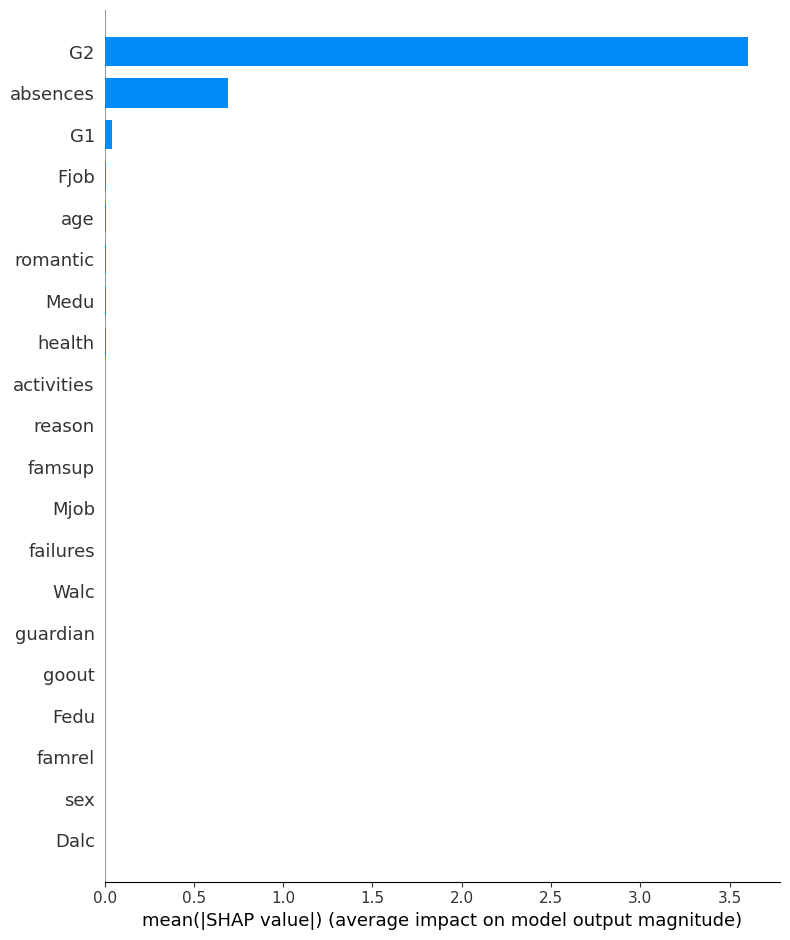

In [ ]:
import shap
from sklearn.ensemble import RandomForestRegressor

# Assuming the best pipeline includes a RandomForestRegressor
best_model = RandomForestRegressor(n_estimators=88, max_depth=15, min_samples_split=13, min_samples_leaf=14, random_state=42)
best_model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [ ]:
print(shap_values)
# Convert SHAP values to a DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

# Save the DataFrame to a CSV file
shap_df.to_csv('shap_values.csv', index=False)

print("SHAP values have been saved to 'shap_values.csv'.")

from google.colab import files

# Download the CSV file
files.download('shap_values.csv')

[[ 0.00000000e+00 -1.71071805e-03  6.54638206e-03 ...  8.40681274e-01
  -2.45825411e-02 -3.04760782e+00]
 [ 0.00000000e+00  5.28700949e-05 -1.07723242e-03 ...  2.82448445e-01
   2.73887890e-02  1.26243390e+00]
 [ 0.00000000e+00  5.92273038e-04 -6.22834138e-03 ...  1.06126233e+00
  -7.25933583e-02 -6.35646450e+00]
 ...
 [ 0.00000000e+00 -1.71071805e-03  1.81775080e-02 ...  8.94295546e-01
   1.70227481e-02 -2.16517269e+00]
 [ 0.00000000e+00  1.73839708e-04 -1.01474140e-03 ...  2.78172243e-01
   7.76599243e-03  3.59107915e+00]
 [ 0.00000000e+00  5.92273038e-04  3.92217116e-03 ...  1.06142294e+00
  -7.58130583e-02 -6.37061050e+00]]
SHAP values have been saved to 'shap_values.csv'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The top 10 features based on the mean absolute SHAP values are:

1. G2: 3.601914
2. absences: 0.689220
3. G1: 0.039508
4. Fjob: 0.009821
5. age: 0.009346
6. romantic: 0.007206
7. Medu: 0.006698
8. health: 0.006133
9. activities: 0.004932
10. reason: 0.004287

It appears that the second-peirod grade has the highest impact on the final grade prediction. So does the first-period grade (although to a much less extent). It does support the belief that past performance supports future performance. It also shows that the number of absences does generally affect a student's performance, as they will be getting less guided material.

Other factors such as student's father's job, their age, whether the student is engaged in a romantic relationship, or their mother's education level only marginally affects their final grade. Every other factor has quite negligible impact.